# Afro-MNIST with SciKit-Learn and skorch

https://github.com/Daniel-Wu/AfroMNIST?tab=readme-ov-file

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
!gdown 1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr

Downloading...
From (original): https://drive.google.com/uc?id=1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr
From (redirected): https://drive.google.com/uc?id=1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr&confirm=t&uuid=9397fb85-a136-4d38-aa04-a438247351f9
To: /content/Afro-MNIST.zip
100% 108M/108M [00:00<00:00, 169MB/s] 


In [ ]:
!unzip Afro-MNIST.zip

Archive:  Afro-MNIST.zip
  inflating: Ethiopic/Ethiopic_MNIST_X_test.npy  
  inflating: Ethiopic/Ethiopic_MNIST_X_train.npy  
  inflating: Ethiopic/Ethiopic_MNIST_y_test.npy  
  inflating: Ethiopic/Ethiopic_MNIST_y_train.npy  
  inflating: NKo/NKo_MNIST_X_test.npy  
  inflating: NKo/NKo_MNIST_X_train.npy  
  inflating: NKo/NKo_MNIST_y_test.npy  
  inflating: NKo/NKo_MNIST_y_train.npy  
  inflating: Osmanya/Osmanya_MNIST_X_test.npy  
  inflating: Osmanya/Osmanya_MNIST_X_train.npy  
  inflating: Osmanya/Osmanya_MNIST_y_test.npy  
  inflating: Osmanya/Osmanya_MNIST_y_train.npy  
  inflating: Vai/Vai_MNIST_X_test.npy  
  inflating: Vai/Vai_MNIST_X_train.npy  
  inflating: Vai/Vai_MNIST_y_test.npy  
  inflating: Vai/Vai_MNIST_y_train.npy  


In [ ]:
cd Ethiopic

/content/Ethiopic


In [ ]:
X_train = np.load("Ethiopic_MNIST_X_train.npy")
y_train = np.load("Ethiopic_MNIST_y_train.npy").astype('int64')
X_test  = np.load("Ethiopic_MNIST_X_test.npy")
y_test  = np.load("Ethiopic_MNIST_y_test.npy").astype('int64')
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

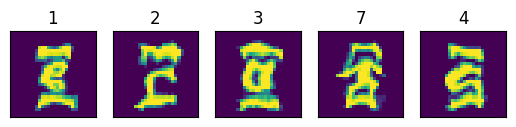

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = 28 * 28
hidden_dims = [int(mnist_dim/8)]
output_dim = 10

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
y_train

array([1, 2, 3, ..., 3, 4, 2])

In [ ]:
net1.fit(X_train, y_train)
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5622       0.9805        0.0971  1.6862
      2        0.1370       0.9868        0.0537  1.4385
      3        0.0962       0.9884        0.0403  1.3871
      4        0.0801       0.9897        0.0341  1.0656
      5        0.0705       0.9905        0.0313  1.0637
      6        0.0635       0.9904        0.0286  1.0511
      7        0.0578       0.9895        0.0292  1.0521
      8        0.0521       0.9908        0.0260  1.0781
      9        0.0507       0.9916        0.0250  1.0233
     10        0.0479       0.9908        0.0259  1.0229
     11        0.0453       0.9918        0.0227  1.0354
     12        0.0452       0.9922        0.0229  1.0300
     13        0.0418       0.9926        0.0223  1.4044
     14        0.0404       0.9926        0.0217  1.3631
     15        0.0399       0.9923        0.0204  1.0243
     16        0.0379       0.9

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.9923

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9101       0.9682        0.1292  1.1489
      2        0.2279       0.9806        0.0623  1.1355
      3        0.1562       0.9870        0.0402  1.1614
      4        0.1262       0.9891        0.0328  1.5238
      5        0.1074       0.9889        0.0301  1.3363
      6        0.0997       0.9902        0.0270  1.1019
      7        0.0936       0.9900        0.0279  1.0996
      8        0.0858       0.9908        0.0249  1.0884
      9        0.0793       0.9902        0.0254  1.0994
     10        0.0748       0.9902        0.0248  1.0888
     11        0.0691       0.9913        0.0232  1.0925
     12        0.0646       0.9922        0.0207  1.1296
     13        0.0637       0.9914        0.0217  1.1124
     14        0.0635       0.9909        0.0231  1.3113
     15        0.0573       0.9920        0.0210  1.5439
     16        0.0561       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9934

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6982       0.9741        0.0923  1.1318
      2        0.1511       0.9831        0.0534  1.1169
      3        0.1114       0.9858        0.0421  1.1324
      4        0.0896       0.9873        0.0372  1.2662
      5        0.0779       0.9889        0.0324  1.5159
      6        0.0694       0.9887        0.0333  1.2571
      7        0.0630       0.9893        0.0294  1.1179
      8        0.0589       0.9906        0.0259  1.0986
      9        0.0552       0.9911        0.0254  1.1095
     10        0.0509       0.9909        0.0244  1.1044
     11        0.0496       0.9913        0.0235  1.1192
     12        0.0461       0.9909        0.0246  1.1357
     13        0.0433       0.9921        0.0208  1.1259
     14        0.0427       0.9924        0.0212  1.0948
     15        0.0376       0.9927        0.0203  1.4190
     16        0.0378       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.9934

In [ ]:
error_mask = y_pred != y_test

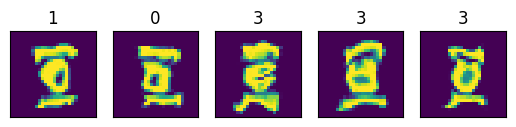

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
[mnist_dim//4, mnist_dim//2]

[196, 392]

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8214       0.9703        0.1020  1.1532
      2        0.1830       0.9807        0.0554  1.1153
      3        0.1258       0.9849        0.0417  1.1045
      4        0.0997       0.9869        0.0359  1.1220
      5        0.0879       0.9876        0.0340  2.0523
      6        0.0807       0.9890        0.0296  1.3969
      7        0.0716       0.9896        0.0291  1.1105
      8        0.0682       0.9893        0.0290  1.1248
      9        0.0651       0.9884        0.0308  1.0983
     10        0.0607       0.9911        0.0247  1.0923
     11        0.0593       0.9912        0.0251  1.1245
     12        0.0554       0.9914        0.0239  1.1558
     13        0.0535       0.9910        0.0246  1.1081
     14        0.0516       0.9912        0.0239  1.1098
     15        0.0492       0.9916        0.0233  1.3146
     16        0.0467       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.9923

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3023       0.1102        2.2968  1.3326
      2        2.0699       0.2836        1.5386  1.2951
      3        1.3983       0.5862        0.9490  1.2625
      4        0.9865       0.8182        0.5206  1.2801
      5        0.7029       0.8345        0.4168  1.7019
      6        0.5546       0.9056        0.3187  1.5852
      7        0.6015       0.9274        0.3018  1.8714
      8        0.4972       0.9347        0.2762  1.2825
      9        0.5802       0.9166        0.3235  1.2735
     10        0.4720       0.9306        0.2702  1.2903
     11        0.4501       0.9409        0.2436  1.2843
     12        0.6189       0.9187        0.2975  1.2849
     13        0.4493       0.9307        0.2589  1.4162
     14        0.4577       0.9340        0.2508  1.7795
     15        0.4316       0.9091        0.2935  1.4044
     16        0.4077       0.9

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.9496

In [ ]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = corr.cpu().detach().numpy()
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

In [ ]:
for i in range(len(nets)):
  for j in range(i + 1, len(nets)):
    correlation = get_correlation(nets[i].module, nets[j].module, torch.tensor(X_test).to(device))
    print("correlation between net" + str(i + 1) + " and net" + str(j + 1) + ":", correlation)

correlation between net1 and net2: 0.57640976
correlation between net1 and net3: 0.57332605
correlation between net1 and net4: 0.5884898
correlation between net1 and net5: 0.3727339
correlation between net2 and net3: 0.6945586
correlation between net2 and net4: 0.7049169
correlation between net2 and net5: 0.50042814
correlation between net3 and net4: 0.6991337
correlation between net3 and net5: 0.48460385
correlation between net4 and net5: 0.45787212


In [ ]:
def get_layers_names(net):
  children = []
  for child in net.named_children():
    if isinstance(child[1], nn.Dropout):
      continue
    elif isinstance(child[1], nn.ModuleList):
      for ch in child[1]._modules:
        children.append((child[1], child[0], ch))
    else:
      children.append(child[0])
  return children

get_layers_names(net2.module)

[(ModuleList(
    (0): Linear(in_features=784, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
  ),
  'hidden',
  '0'),
 (ModuleList(
    (0): Linear(in_features=784, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
  ),
  'hidden',
  '1'),
 'output']

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# def get_outputs(net, test):
#   layers = get_layers_names(net)
#   layer_num = 0
#   layer_nums = None
#   Ts = None
#   for layer in layers:
#     if isinstance(layer[0], nn.ModuleList):
#       net._modules[layer[1]]._modules[layer[2]].register_forward_hook(get_activation(layer[2]))
#       out = net(test)
#       output = activation[layer[2]]
#     else:
#       getattr(net, layer).register_forward_hook(get_activation(layer))
#       out = net(test)
#       output = activation[layer]
#     Ts = torch.cat((Ts, output), 1) if Ts is not None else output
#     l = torch.ones_like(output) * layer_num
#     layer_nums = torch.cat((layer_nums, l), 1) if layer_nums is not None else l
#     layer_num += 1
#   return Ts, layer_nums


# get_outputs(net2.module, torch.tensor(X_test).to(device))

# Convolutional Network


In [ ]:
# XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [ ]:
# XCnn_train.shape, y_train.shape

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3426       0.9981        0.0072  2.7113
      2        0.0374       0.9991        0.0034  1.8539
      3        0.0246       0.9991        0.0028  2.2127
      4        0.0164       0.9999        0.0004  1.8429
      5        0.0142       0.9998        0.0007  1.8447
      6        0.0147       0.9998        0.0004  1.9946
      7        0.0125       0.9997        0.0010  2.2075
      8        0.0103       0.9998        0.0004  1.8280
      9        0.0098       0.9998        0.0003  1.8179
     10        0.0105       0.9997        0.0010  1.7982


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9998

In [ ]:
X_test.shape

(10000, 784)

In [ ]:
for i in range(len(nets)):
  correlation = get_correlation(nets[i].module, cnn.module, torch.tensor(X_test[:10]).to(device))
  print("correlation between net" + str(i + 1) + " and cnn:", correlation)

correlation between net1 and cnn: 0.58829004
correlation between net2 and cnn: 0.628615
correlation between net3 and cnn: 0.72999936
correlation between net4 and cnn: 0.71836776
correlation between net5 and cnn: 0.059317864
